In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
import pickle
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score 

%load_ext autoreload
%autoreload 2

file_path = "../data/carotenoid_training_data.csv"
df = pd.read_csv(file_path)
INPUT_VARS = df.columns[:-1]
INPUT_VARS = list(INPUT_VARS.values)
RESPONSE_VARS = [df.columns[-1]]

print(f"Input variables: {INPUT_VARS}" f"\nResponse variable: {RESPONSE_VARS}")
print(f"Shape of the dataframe: {df.shape}")


# Calculate bounds of proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float = 0.10):
    bounds = pd.DataFrame(columns=input_vars)
    X = df[input_vars]
    for col in input_vars:
        MAX = X[col].max()
        MIN = X[col].min()
        DELTA = MAX - MIN
        lb = MIN - epsilon * DELTA
        ub = MAX + epsilon * DELTA
        if lb < 0:
            lb = 0
        bounds.loc["min", col] = lb
        bounds.loc["max", col] = ub
    return bounds


# Create train/test sets
df.sort_values(by="prod", ascending=False, inplace=True)
test = df[:3].copy()
train = df[3:].copy()

X_train = train.drop("prod", axis=1)
y_train = train["prod"].values.ravel()

X_test = test.drop("prod", axis=1)
y_test = test["prod"].values.ravel()

bounds = get_bounds(train, INPUT_VARS)
display(bounds)

Input variables: ['ERG8', 'ERG10', 'ERG12', 'ERG13', 'ERG19', 'ERG20', 'IDI1', 'tHMG1']
Response variable: ['prod']
Shape of the dataframe: (168, 9)


ERG8      ERG10      ERG12      ERG13      ERG19      ERG20  \
min          0          0          0          0          0          0   
max  21.723829  21.762191  25.871048  23.314336  21.509215  22.215345   

         IDI1      tHMG1  
min         0          0  
max  6.946964  20.623585

In [17]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Linear Regression
linear_param_grid = {
    'fit_intercept': [True, False],
}

# Ridge Regression
ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100],
    'fit_intercept': [True, False],
}

# Lasso Regression
lasso_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100],
    'fit_intercept': [True, False],
}

# K-Nearest Neighbors Regression
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Random Forest Regression
rf_param_grid = {
    'n_estimators': [5, 10, 20, 25, 50],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Support Vector Regression
svr_param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1.0, 10.0],
    'epsilon': [0.1, 0.01, 0.001],
    'gamma': [1, 0.1, 0.01, 0.001]
}

# CatBoost Regression
catboost_param_grid = {
    'iterations': [10, 30, 50],
    'learning_rate': [0.01, 0.05, 0.1, 1.0],
    'depth': [4, 6, 8, 10, 12]
}

# LightGBM Regression
lgbm_param_grid = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'num_leaves': [3, 5, 12, 20],
    'learning_rate': [0.01, 0.1, 1.0, 10.0],
    'n_estimators': [5, 10, 20, 50]
}

# XGBoost Regression
xgb_param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 1.0],
    'n_estimators': [10, 25, 30, 50, 100],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5]
}

def nestedCV(model, p_grid, X, y):
    print(model.__class__.__name__)
    nested_scores = []
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = RandomizedSearchCV(estimator=model, scoring='neg_mean_absolute_error', param_distributions=p_grid, cv=inner_cv, n_iter=100)
    nested_score = cross_val_score(grid, X=X, y=y, scoring='neg_mean_absolute_error', cv=outer_cv)
    nested_scores.append(list(nested_score))
    return model, nested_scores

In [18]:
import warnings
warnings.filterwarnings("ignore")

nested_catboost, nested_catboost_scores = nestedCV(CatBoostRegressor(verbose=False), catboost_param_grid, X_train, y_train)
nested_lgbm, nested_lgbm_scores = nestedCV(LGBMRegressor(), lgbm_param_grid, X_train, y_train)
nested_xgb, nested_xgb_scores = nestedCV(XGBRegressor(n_jobs=-1), xgb_param_grid, X_train, y_train)
nested_LR, nested_LR_scores = nestedCV(LinearRegression(), linear_param_grid, X_train, y_train)
nested_ridge, nested_ridge_scores = nestedCV(Ridge(), ridge_param_grid, X_train, y_train)
nested_lasso, nested_lasso_scores = nestedCV(Lasso(), lasso_param_grid, X_train, y_train)
nested_knn, nested_knn_scores = nestedCV(KNeighborsRegressor(), knn_param_grid, X_train, y_train)
nested_rf, nested_rf_scores = nestedCV(RandomForestRegressor(), rf_param_grid, X_train, y_train)
nested_svr, nested_svr_scores = nestedCV(SVR(), svr_param_grid, X_train, y_train)

CatBoostRegressor
LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 88, number of used features: 8
[LightGBM] [Info] Start training from score 4.323997
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

In [19]:
nested_scores_LR = [-item for sublist in nested_LR_scores for item in sublist]
nested_scores_ridge = [-item for sublist in nested_ridge_scores for item in sublist]
nested_scores_lasso = [-item for sublist in nested_lasso_scores for item in sublist]
nested_scores_knn = [-item for sublist in nested_knn_scores for item in sublist]
nested_scores_rf = [-item for sublist in nested_rf_scores for item in sublist]
nested_scores_svr = [-item for sublist in nested_svr_scores for item in sublist]
nested_scores_catboost = [-item for sublist in nested_catboost_scores for item in sublist]
nested_scores_lgbm = [-item for sublist in nested_lgbm_scores for item in sublist]
nested_scores_xgb = [-item for sublist in nested_xgb_scores for item in sublist]

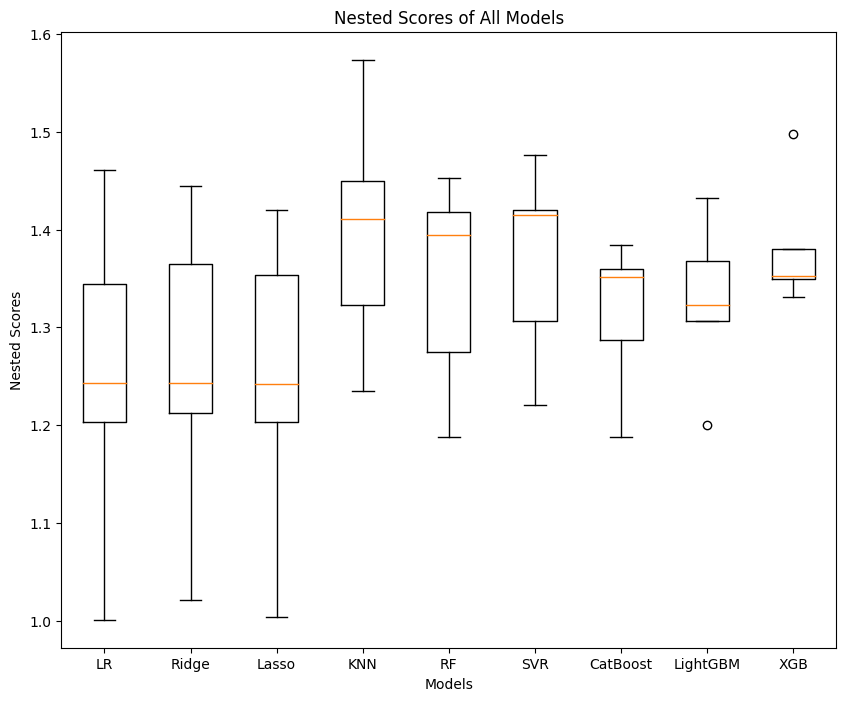

In [20]:
# Combine all nested scores
nested_scores = [
    nested_scores_LR,
    nested_scores_ridge,
    nested_scores_lasso,
    nested_scores_knn,
    nested_scores_rf,
    nested_scores_svr,
    nested_scores_catboost,
    nested_scores_lgbm,
    nested_scores_xgb
]

# Create a boxplot
plt.figure(figsize=(10,8))
plt.boxplot(nested_scores, labels=["LR", "Ridge", "Lasso", "KNN", "RF", "SVR", "CatBoost", "LightGBM", "XGB"])
plt.xlabel("Models")
plt.ylabel("Nested Scores")
plt.title("Nested Scores of All Models")
plt.show()


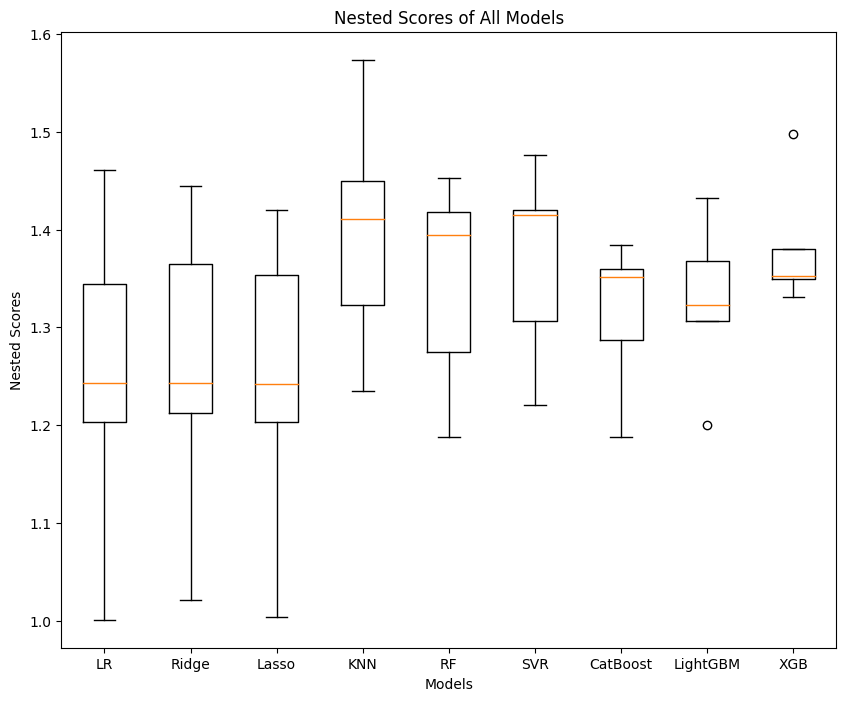

In [21]:
import optuna
from sklearn.model_selection import cross_val_score
import xgboost as xgb

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.001, 1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.001, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    
    model = xgb.XGBRegressor(**params)
    
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mae = -scores.mean()
    
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

[I 2024-02-13 16:24:34,138] A new study created in memory with name: no-name-8a04c158-b615-480c-b911-a7c929a1713b
[I 2024-02-13 16:24:35,306] Trial 0 finished with value: 1.8183901481117677 and parameters: {'booster': 'gblinear', 'max_depth': 10, 'learning_rate': 0.04538173652944216, 'subsample': 0.8924264267312736, 'colsample_bytree': 0.9949713187144937, 'reg_alpha': 0.5149615772944847, 'reg_lambda': 0.17002097601854138, 'min_child_weight': 3}. Best is trial 0 with value: 1.8183901481117677.
[I 2024-02-13 16:24:36,265] Trial 1 finished with value: 1.774921418331982 and parameters: {'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.04757511863313525, 'subsample': 0.7969862479810764, 'colsample_bytree': 0.839650356632129, 'reg_alpha': 0.1946365238406854, 'reg_lambda': 0.4797750961735533, 'min_child_weight': 7}. Best is trial 1 with value: 1.774921418331982.
[I 2024-02-13 16:24:37,086] Trial 2 finished with value: 1.806609497873269 and parameters: {'booster': 'gbtree', 'max_depth':

XGBRegressor(base_score=None, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5768353127139889, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.09999198553732215, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
def bootstrap(X, y, model: object, n: int = 100):
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=i
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
    return mae_values

mae_values = bootstrap(X_train, y_train, final_model)
print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")
final_model.fit(X_train, y_train)

with open("../models/xgb_carotenoid.pkl", "wb") as f:
    final_model.fit(X_train, y_train)
    pickle.dump(final_model, f)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 21.53it/s]

Bootstraped Mean(MAE) = 1.2560836730825153


#### Explainable AI 

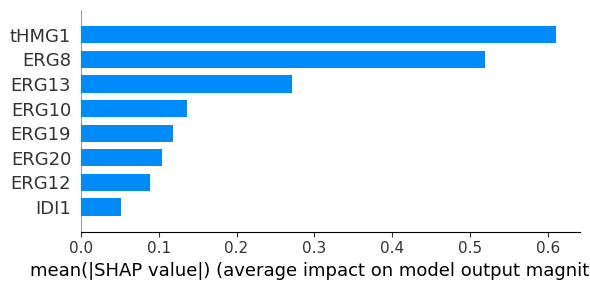

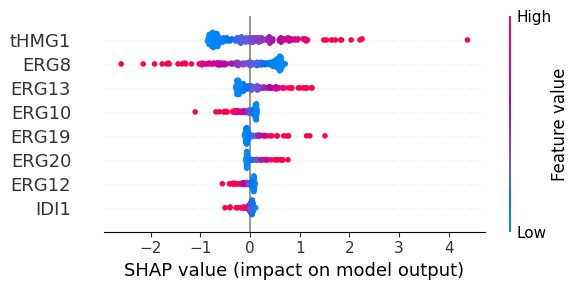

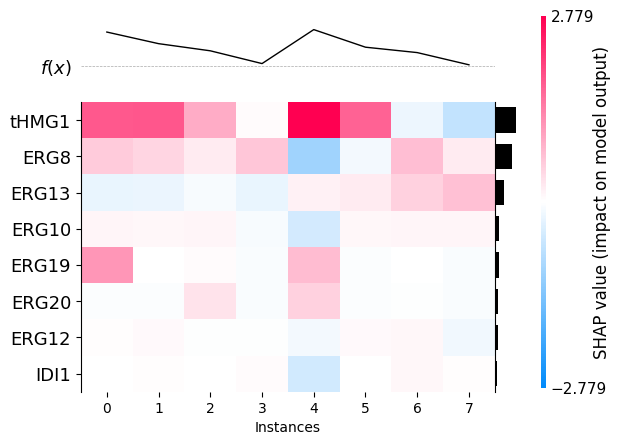

In [28]:
import shap
import matplotlib.pyplot as plt
from alibi.explainers import ALE, PartialDependence, plot_ale, plot_pd

def pdplot(X: np.array, col: str, model: object, ice: bool = False):
    shap.plots.partial_dependence(
        col,
        model.predict,
        X,
        ice=ice,
        model_expected_value=True,
        feature_expected_value=True,
        show=True,
    )


def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])


explainer = shap.Explainer(final_model.predict, train[INPUT_VARS])
shap_values = explainer(train[INPUT_VARS])
shap.summary_plot(shap_values, train[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, train[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(0), plot_width=6)

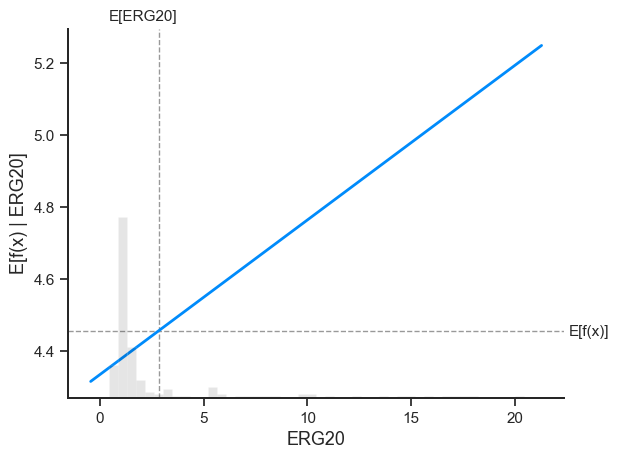

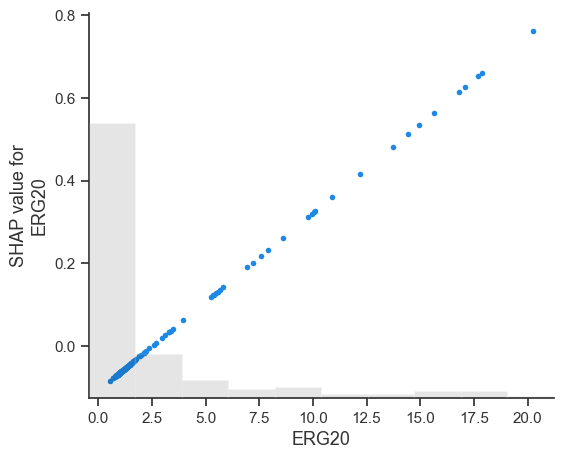

In [57]:
feature = "ERG20"
pdplot(train[INPUT_VARS], feature, final_model, ice=False)
shap_scatter(feature)

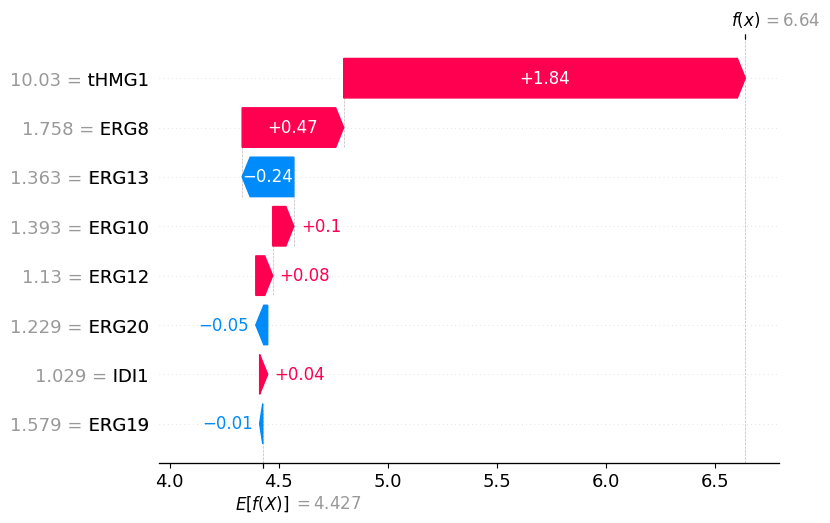

In [45]:
idx = 4
shap.plots.waterfall(shap_values[idx])

In [35]:
test

ERG8     ERG10     ERG12      ERG13     ERG19     ERG20      IDI1  \
159  8.055299  6.361974  2.989112  10.030468  2.530277  1.613322  1.603377   
117  4.382417  1.525546  1.180070   1.533178  1.411179  1.349900  1.508734   
155  7.336543  3.662594  7.673811   2.682688  2.195583  4.418530  1.014994   

         tHMG1       prod  
159  12.883930  10.563800  
117  19.775550  10.401666  
155  13.672108   9.522851

# Sampling

In [59]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds["tHMG1"].loc["min"] = 17
sampling_bounds["tHMG1"].loc["max"] = bounds["tHMG1"].loc["max"]

sampling_bounds["ERG8"].loc["min"] = bounds["ERG8"].loc["min"]
sampling_bounds["ERG8"].loc["max"] = 5

sampling_bounds["ERG10"].loc["min"] = 1.75
sampling_bounds["ERG10"].loc["max"] = 7

sampling_bounds["ERG12"].loc["min"] = bounds["ERG12"].loc["min"]
sampling_bounds["ERG12"].loc["max"] = 1.0

sampling_bounds["ERG13"].loc["min"] = 10
sampling_bounds["ERG13"].loc["max"] = bounds["ERG13"].loc["max"]

sampling_bounds["ERG19"].loc["min"] = bounds["ERG19"].loc["min"]
sampling_bounds["ERG19"].loc["max"] = 0.7

sampling_bounds["ERG20"].loc["min"] = 3.0
sampling_bounds["ERG20"].loc["max"] = bounds["ERG20"].loc["max"]

sampling_bounds["IDI1"].loc["min"] = bounds["IDI1"].loc["min"]
sampling_bounds["IDI1"].loc["max"] = 2



# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(10000)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df.head(10)

ERG8     ERG10     ERG12      ERG13     ERG19      ERG20      IDI1  \
1495  0.044176  2.011531  0.439668  23.312414  0.576410  15.512271  0.345029   
3597  0.199663  3.499162  0.781204  22.158269  0.252282  20.230562  0.341067   
404   0.242716  2.396690  0.018275  23.062126  0.158294  20.830892  1.874466   
7835  0.797871  6.439324  0.307303  23.165477  0.569637  21.613109  0.034885   
4729  0.042995  2.566920  0.250329  19.559826  0.347366  21.170986  0.318974   
6221  0.101307  3.447951  0.888593  23.069876  0.332509  18.119661  1.183366   
5982  0.227606  4.339832  0.291637  19.990074  0.610868  22.075235  0.528135   
223   0.090649  2.768009  0.916856  21.937943  0.478560  21.588540  1.954961   
2793  0.160207  3.289104  0.634332  22.341297  0.639217  15.098908  0.209726   
7986  0.065317  3.428731  0.893763  21.335962  0.040214  20.814295  0.284730   

          tHMG1       pred  
1495  20.498074  12.166422  
3597  20.581858  12.147426  
404   20.311469  12.084951  
7835  20.566089  12.055960  
4729  20.332047  12.034451  
6221  20.469314  12.030409  
5982  20.514435  12.011164  
223   20.205067  11.998007  
2793  20.521490  11.993641  
7986  20.092397  11.981981

# Counterfactuals (`DiCE`)

In [62]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = train.sort_values("prod", ascending=False).index
X_train = X_train.loc[sorted_idx]

def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = X_train[0:1]

d = dice_ml.Data(
    dataframe=train, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=final_model, backend="sklearn", model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(
    query_instances,
    total_CFs=10,
    desired_range=[5, 9],
    permitted_range=bounds_to_dict(sampling_bounds),
)

cf_df = e1.cf_examples_list[0].final_cfs_df
e1.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:10<00:00, 70.72s/it]

Query instance (original outcome : 5.747567653656006)


ERG8     ERG10     ERG12      ERG13     ERG19     ERG20      IDI1  \
0  0.322517  1.081516  0.214028  11.495731  1.872004  1.773278  0.470616   

     tHMG1      prod  
0  2.94563  5.747568


Diverse Counterfactual set (new outcome: [5, 9])


ERG8       ERG10       ERG12        ERG13       ERG19       ERG20  \
0  3.19189239   5.8519596           -  10.07587781         0.0  4.26605994   
0  4.74438732  2.96481794  0.95021011  10.10922629  0.06528926  3.01198501   
0  4.87096004  4.48697192  0.63970342  10.66324199  0.21188876  3.27673567   
0  4.18928934  2.68914421  0.28917588  10.73865124  0.26345773  3.03966752   
0  4.44074812  3.16852417  0.99883379  10.72727484  0.53458207  3.26651215   
0  4.11438961  5.46698811  0.86901533  10.62590859  0.55352386         3.0   
0  3.79315655  6.77685592  0.18424257  10.31465642   0.6570729  3.21232022   
0  4.72334387  6.05941246  0.71458291  11.68638305  0.50894122  3.25520395   

         IDI1        tHMG1               prod  
0  1.43735428         17.0  8.748571395874023  
0  0.57655223  17.44043061  8.820682525634766  
0  0.41114173  17.01553136  8.668310165405273  
0   0.9030611  17.22632108  8.921541213989258  
0  0.09517639  17.03249761  8.885575294494629  
0   0.8327562  17.33720494  8.790579795837402  
0  0.18987167  17.53377797  8.895953178405762  
0  0.15445946    17.661459  8.901846885681152

# PCA

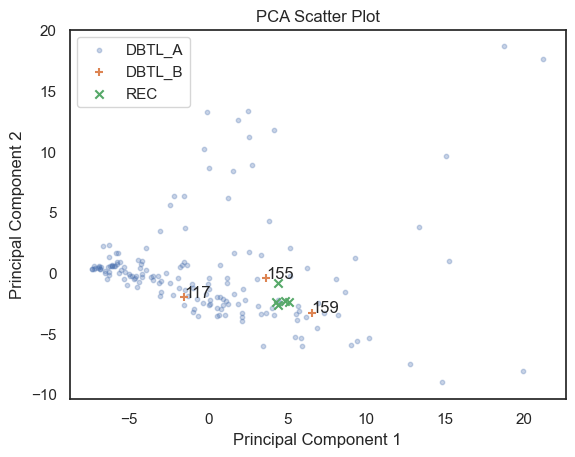

          prod
159  10.563800
117  10.401666
155   9.522851


In [71]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

pca = PCA(n_components=2)
pca.fit(train[INPUT_VARS])
trans_df_A = pca.transform(train[INPUT_VARS])
trans_df_B = pca.transform(test[INPUT_VARS])
trans_rec = pca.transform(cf_df[INPUT_VARS].head(5)) 
# trans_rec = pca.transform(sample_df[INPUT_VARS].head(3))

# Plot
plt.scatter(trans_df_A[:, 0], trans_df_A[:, 1], label="DBTL_A", alpha=0.3, s=10)
plt.scatter(trans_df_B[:, 0], trans_df_B[:, 1], label="DBTL_B", marker='+')
for i, txt in enumerate(test.index):
    plt.annotate(txt, (trans_df_B[i, 0], trans_df_B[i, 1]))
plt.scatter(trans_rec[:, 0], trans_rec[:, 1], label="REC", marker='x')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.legend()
plt.show()

print(test[RESPONSE_VARS].sort_values(by='prod', ascending=False))